PINN_oscillator_1D_cpu_t_mu_in_progress

# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

# Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

Here you can see an overview of the 2 dimensional space (t, mu):

<img src="excalidraw1.JPG" width="750">

## Step 1: Definition and initialization

In [1]:
### Import all what you need:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import numpy as np

import matplotlib.pyplot as plt

import time

In [2]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [3]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!
learning_rate =  1e-3         # learning rate
lambda1, lambda2 = 1e-1, 1e-4 # loss term hyperparameters
epochs = 20001

### Initial, training and test points generation:

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$


In [4]:
#### Generation of t and mu initial points (Initial condition 1) 
point_resolution = 40

ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 1: \n \t [t, mu]: \n{ic1_t_mu}")
# print(f"\n Initial condition 1: \n \t u(t=0, mu) = 1: \n {ic1_scope}")
# print(f"\n Shapes of [t, mu] and u(t=0, mu) = 1: \n\t{ic1_t_mu.shape}, {ic1_scope.shape}")

#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$

In [5]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)

#print(f"Initial condition 2: \n \t [t, mu]: \n{ic2_t_mu}")
#print(f"\n Initial condition 2: \n \t du/dt(t=0, mu) = 0: \n\t {ic2_scope}")
#print(f"\n Shapes of [t, mu] and du/dt(t=0, mu) = 0: \n\t {ic2_t_mu.shape}, {ic2_scope.shape}")

#### Generation of physical domain training points: 

In [6]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

#print(f" Point seed list for mesh grid domain points: \n \t {physic_in_t_mu}")
#print(f"Domain training points: \n \t: {physic_domain_t_mu}")
#print(f"Size of Domain training points: \n \t {physic_domain_t_mu.size()}")

#### Generation of testing points:

In [7]:
#### Generation of t and mu test points within the domain:
point_resolution_test = 100

# Testing points:
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)

#print(f"Point seed list for mesh grid test points: \n \t \n \t: {test_in_t_mu}")
#print(f"Test points \n \t [t, mu]: \n \t {test_domain_t_mu}")
#print(f"Size of the test domain points: \n \t {test_domain_t_mu.size()}")

### Exact solution:

In [8]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [9]:
# Example to check if it works (calculation of the exact solution):
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#u_exact.view(-1,1)
#u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

In [10]:
#physic_in_t_mu[0]

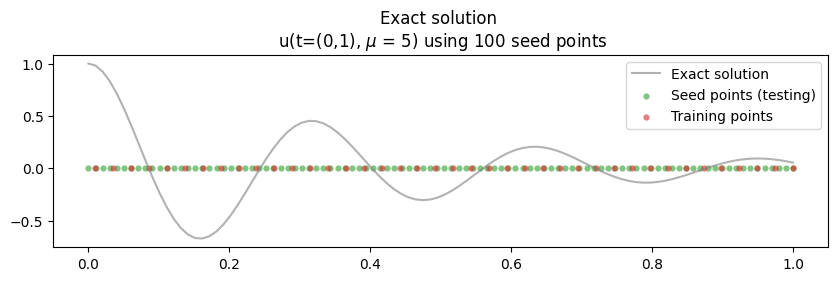

In [11]:
# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_in_t_mu[0], 
        u_exact, 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points (testing)")
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= "Training points")

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {point_resolution_test} seed points")
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [12]:
class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, N_OUTPUT = 1, hidden_layers = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        #self.fcs = nn.Sequential(
        #    nn.Linear(N_INPUT, hidden_layers[0]),
        #    self.activation
        #)
        self.fcs = nn.Linear(N_INPUT, hidden_layers[0])

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_layers[i], hidden_layers[i + 1]),
                self.activation
            ) for i in range(len(hidden_layers) - 1)
        ])

        self.fce = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)


    def forward(self, x):
        x = self.activation(self.fcs(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fce(x)
        return x
    
    def initialize_parameters(self, initialization):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")

    def plot_weights(self):
        weights_biases_dict = self.state_dict()
        #weights_biases_dict = {key: value for key, value in state_dict.items()}
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = 8)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = 8)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = 8)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = 8)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = 8, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network')
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.set_label('Range of Weights and Biases') 
        
        # Show the plots
        plt.show()

## STEP 3: Instantiate the Model Class

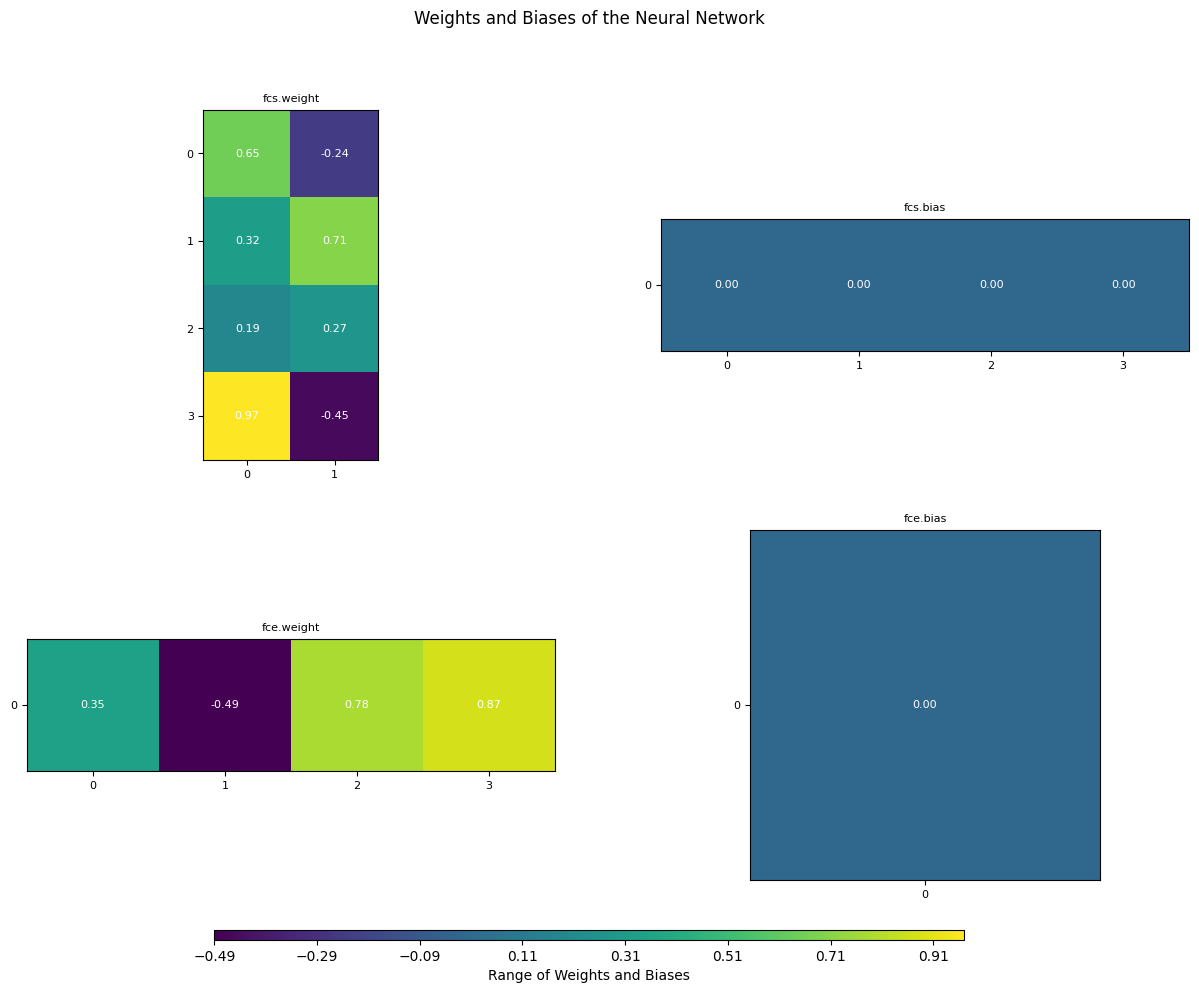

In [13]:
original_input_size = 2
original_hidden_layers = [4]
original_output_size = 1
original_model = FCN(original_input_size, original_output_size, original_hidden_layers, activation='Tanh', initialization='Xavier')
original_model.plot_weights()

### Checking the model using test points and a constant mu value:

In [14]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")

In [15]:
# NO es necesario porque se mantiene constante mu
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()
#print(f"Domain training points: \n \t: {test_domain_t_constant_mu}")

In [16]:
test_predicted = original_model(test_in_t_constant_mu)
#test_predicted.size()
#test_predicted

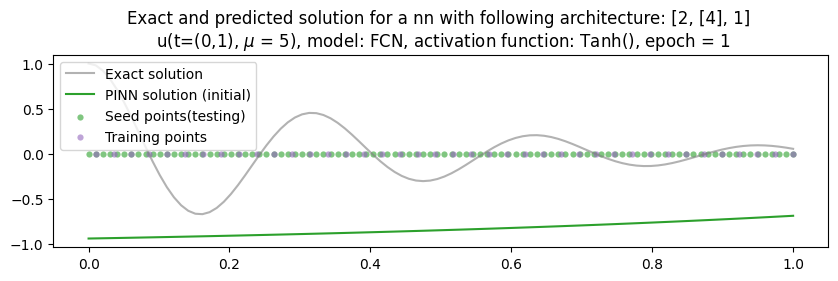

In [17]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
### model and activation has to be manually adapted
plt.title(f"Exact and predicted solution for a nn with following architecture: [{original_input_size}, {original_hidden_layers}, {original_output_size}] \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation}, epoch = 1")
plt.legend()
plt.show()

## STEP 4: Selection of the Optimizer

In [18]:
### model.parameters has to be manually adapted
optimiser = torch.optim.Adam(original_model.parameters(), lr= learning_rate)
optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## STEP 5: Training the PINN

Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(13.549473762512207) = loss1(3.6101927757263184) + 0.1 * loss2(0.1325249969959259) + 0.0001 * loss3(99260.28125)


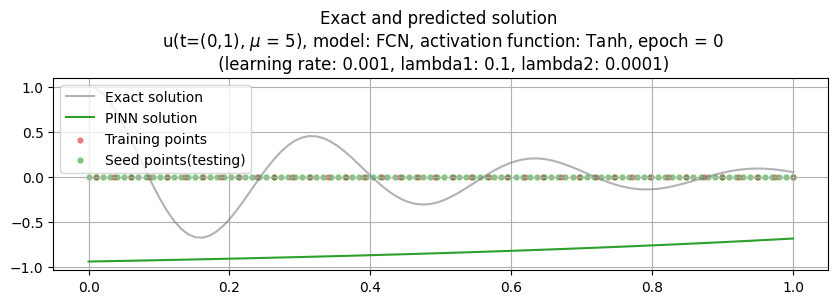

Saved the checkpoint corresponding to epoch: 0
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.7958208918571472) = loss1(0.6533991098403931) + 0.1 * loss2(0.1208324059844017) + 0.0001 * loss3(1303.3857421875)


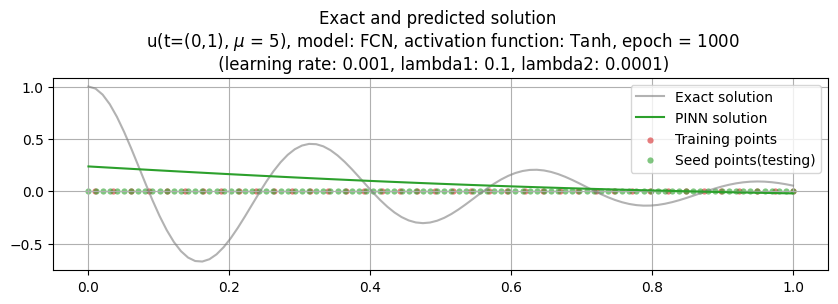

Saved the checkpoint corresponding to epoch: 1000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.7417866587638855) = loss1(0.556733250617981) + 0.1 * loss2(0.41176638007164) + 0.0001 * loss3(1438.76806640625)


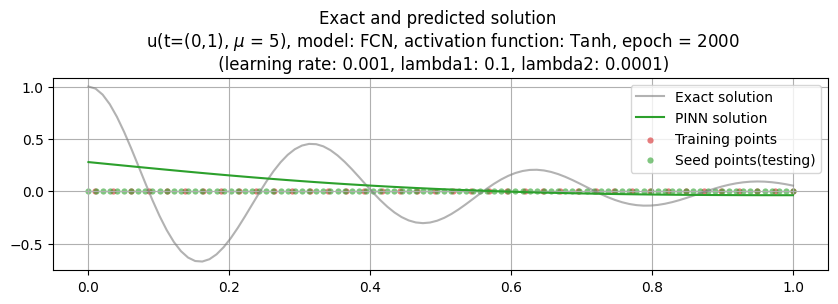

Saved the checkpoint corresponding to epoch: 2000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.7316128015518188) = loss1(0.5237926244735718) + 0.1 * loss2(0.5762709379196167) + 0.0001 * loss3(1501.9306640625)


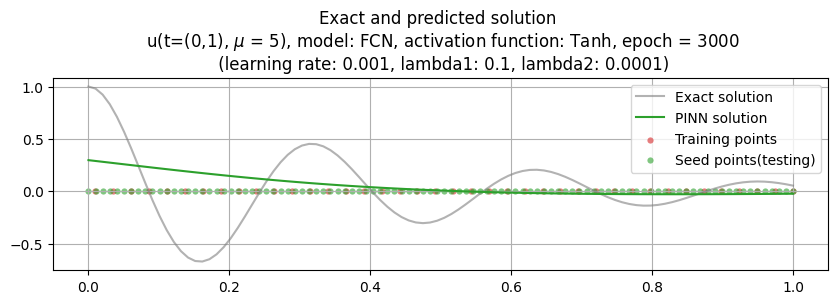

Saved the checkpoint corresponding to epoch: 3000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.7123004198074341) = loss1(0.5049824118614197) + 0.1 * loss2(0.5013944506645203) + 0.0001 * loss3(1571.785888671875)


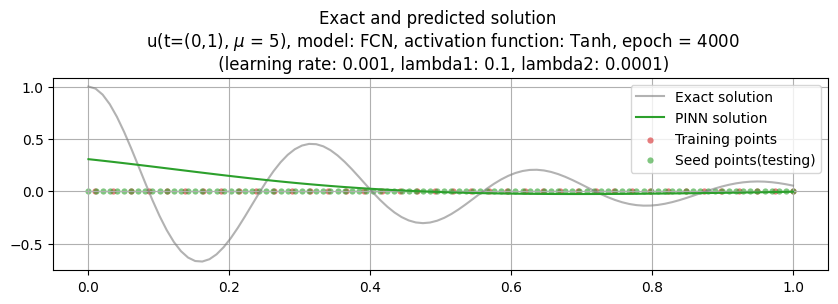

Saved the checkpoint corresponding to epoch: 4000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.6810125112533569) = loss1(0.47235336899757385) + 0.1 * loss2(0.4139494001865387) + 0.0001 * loss3(1672.6424560546875)


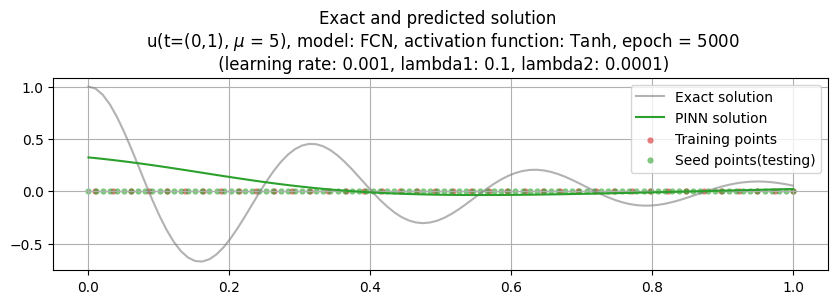

Saved the checkpoint corresponding to epoch: 5000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.6429316997528076) = loss1(0.4292011857032776) + 0.1 * loss2(0.3362555205821991) + 0.0001 * loss3(1801.050048828125)


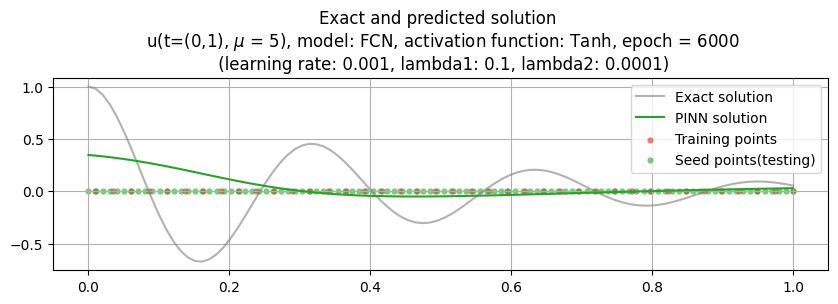

Saved the checkpoint corresponding to epoch: 6000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.5734935998916626) = loss1(0.3663427531719208) + 0.1 * loss2(0.19083356857299805) + 0.0001 * loss3(1880.675048828125)


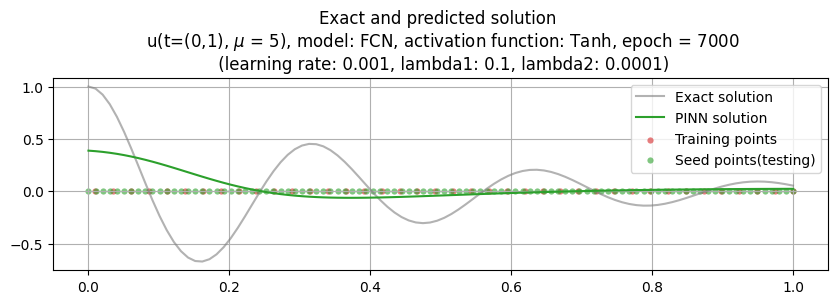

Saved the checkpoint corresponding to epoch: 7000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.46739625930786133) = loss1(0.2719031572341919) + 0.1 * loss2(0.07354997843503952) + 0.0001 * loss3(1881.381103515625)


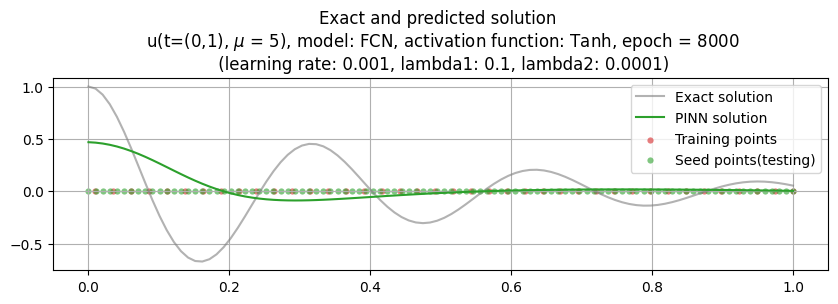

Saved the checkpoint corresponding to epoch: 8000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.3483949303627014) = loss1(0.1761736273765564) + 0.1 * loss2(0.023564491420984268) + 0.0001 * loss3(1698.6485595703125)


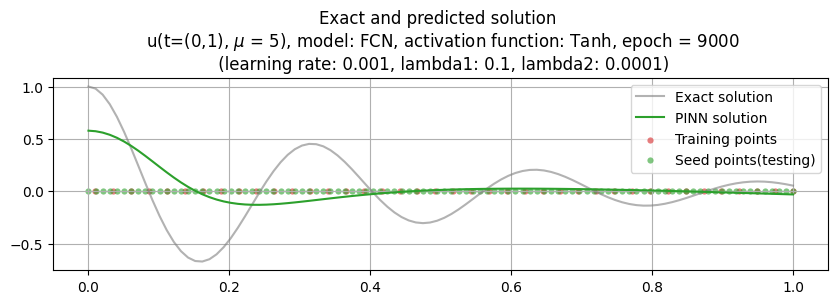

Saved the checkpoint corresponding to epoch: 9000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.24188369512557983) = loss1(0.10050752013921738) + 0.1 * loss2(0.00566187035292387) + 0.0001 * loss3(1408.0999755859375)


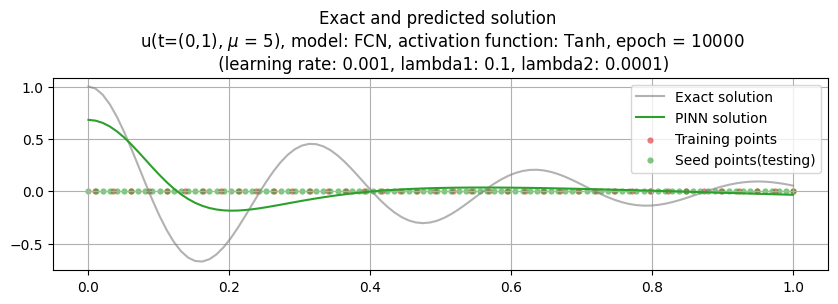

Saved the checkpoint corresponding to epoch: 10000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.16296859085559845) = loss1(0.0543329194188118) + 0.1 * loss2(0.0013465636875480413) + 0.0001 * loss3(1085.0101318359375)


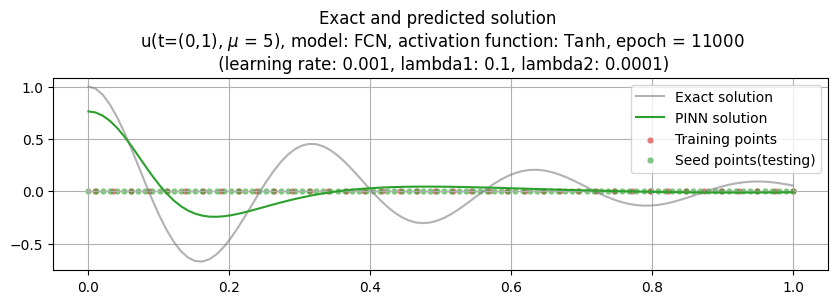

Saved the checkpoint corresponding to epoch: 11000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.12000556290149689) = loss1(0.02792007103562355) + 0.1 * loss2(0.0004632414202205837) + 0.0001 * loss3(920.3917236328125)


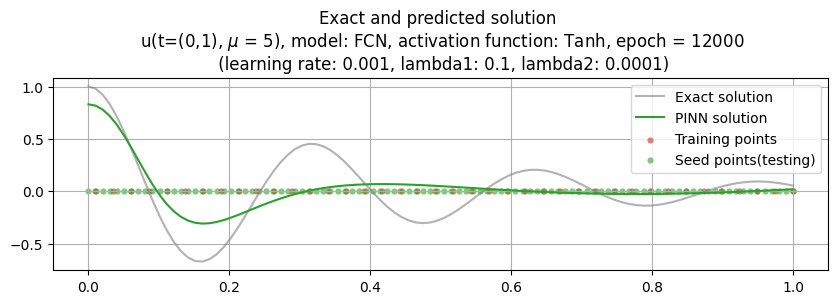

Saved the checkpoint corresponding to epoch: 12000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.10902265459299088) = loss1(0.018013212829828262) + 0.1 * loss2(0.00023842905648052692) + 0.0001 * loss3(909.8560180664062)


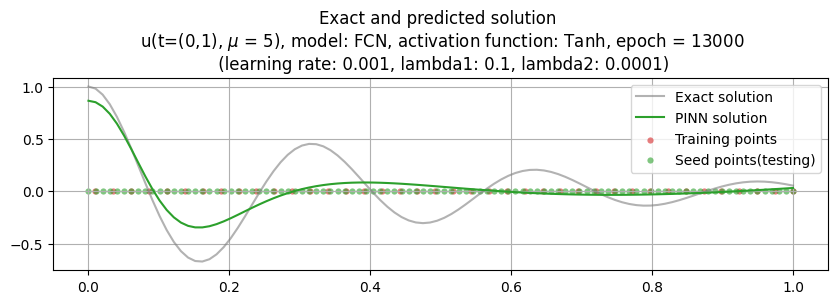

Saved the checkpoint corresponding to epoch: 13000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.10477657616138458) = loss1(0.015596938319504261) + 0.1 * loss2(0.00023526065342593938) + 0.0001 * loss3(891.5611572265625)


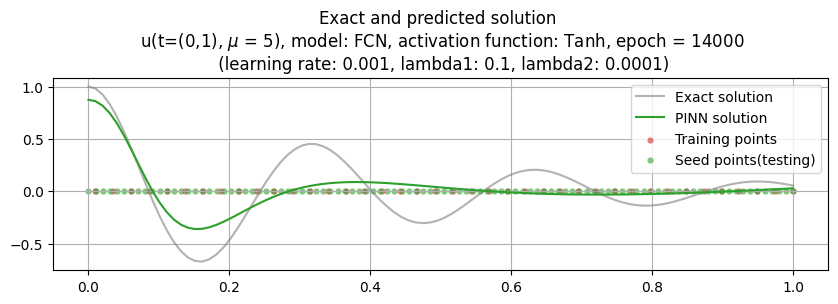

Saved the checkpoint corresponding to epoch: 14000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.10057183355093002) = loss1(0.01443354319781065) + 0.1 * loss2(0.0001866947131929919) + 0.0001 * loss3(861.1962280273438)


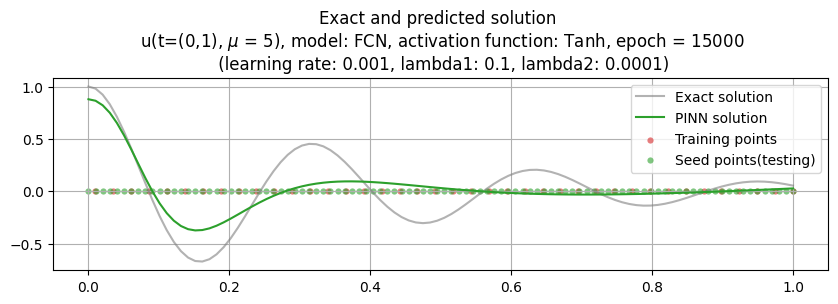

Saved the checkpoint corresponding to epoch: 15000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.09493343532085419) = loss1(0.013386842794716358) + 0.1 * loss2(0.0001921596413012594) + 0.0001 * loss3(815.2737426757812)


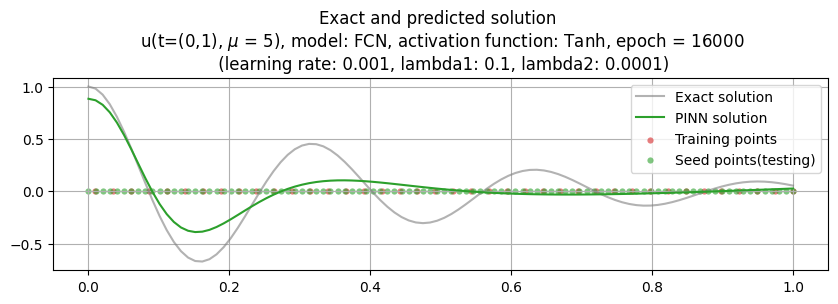

Saved the checkpoint corresponding to epoch: 16000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.08725865930318832) = loss1(0.012133877724409103) + 0.1 * loss2(0.000212130558793433) + 0.0001 * loss3(751.03564453125)


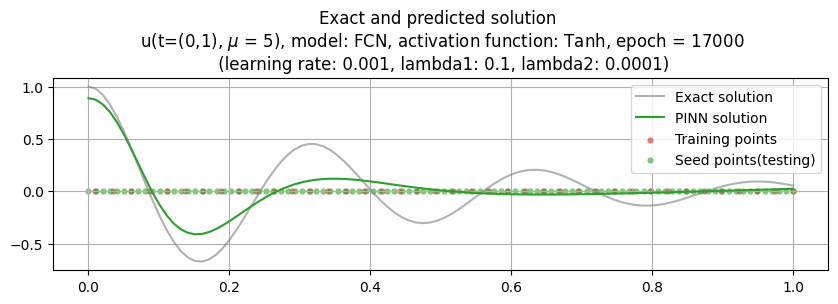

Saved the checkpoint corresponding to epoch: 17000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.07791599631309509) = loss1(0.010459278710186481) + 0.1 * loss2(6.580835179192945e-05) + 0.0001 * loss3(674.5013427734375)


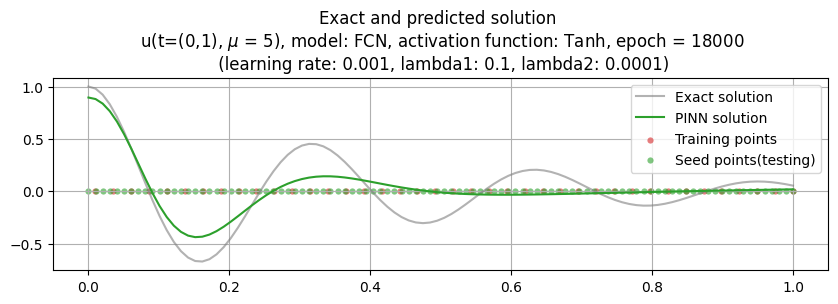

Saved the checkpoint corresponding to epoch: 18000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.06855051219463348) = loss1(0.008497386239469051) + 0.1 * loss2(7.609038584632799e-05) + 0.0001 * loss3(600.4551391601562)


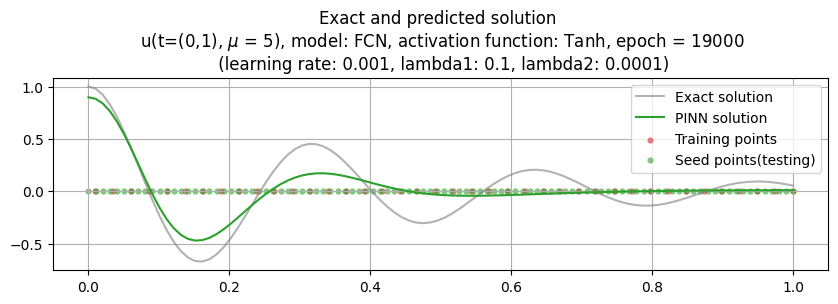

Saved the checkpoint corresponding to epoch: 19000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.06064967066049576) = loss1(0.007945936173200607) + 0.1 * loss2(0.0002676783478818834) + 0.0001 * loss3(526.7697143554688)


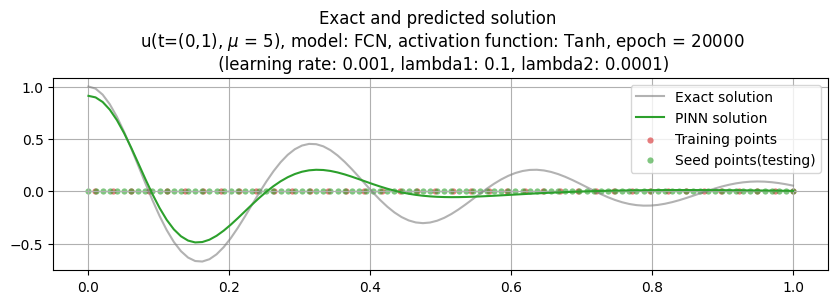

Saved the checkpoint corresponding to epoch: 20000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.05533173307776451) = loss1(0.006902711931616068) + 0.1 * loss2(0.00022249070752877742) + 0.0001 * loss3(484.0677490234375)


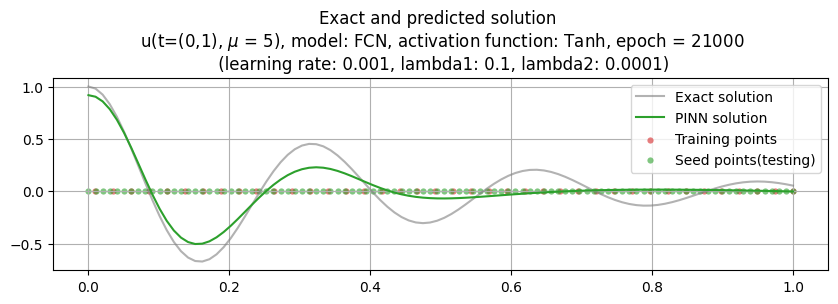

Saved the checkpoint corresponding to epoch: 21000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.051885105669498444) = loss1(0.005823520012199879) + 0.1 * loss2(1.5164943079071236e-06) + 0.0001 * loss3(460.6143493652344)


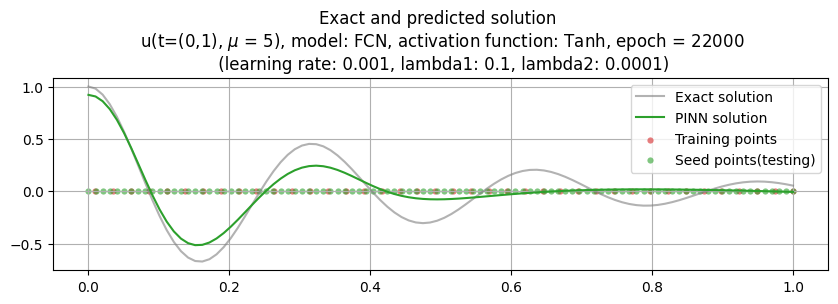

Saved the checkpoint corresponding to epoch: 22000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.04957137256860733) = loss1(0.005646726116538048) + 0.1 * loss2(0.000143550947541371) + 0.0001 * loss3(439.1029357910156)


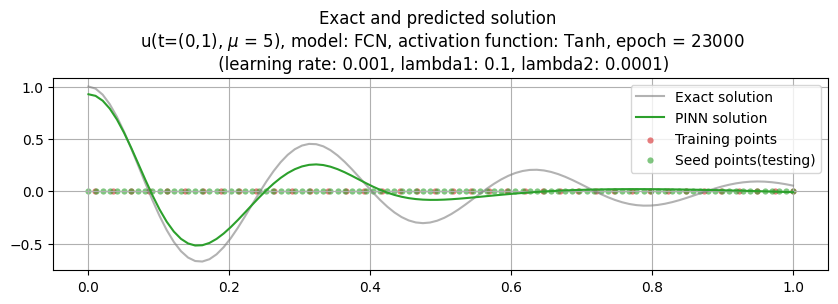

Saved the checkpoint corresponding to epoch: 23000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.04815227538347244) = loss1(0.005534564144909382) + 0.1 * loss2(0.0003962510672863573) + 0.0001 * loss3(425.7808837890625)


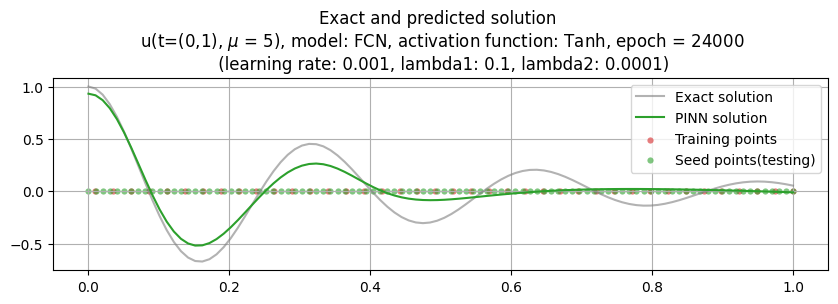

Saved the checkpoint corresponding to epoch: 24000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.04712890833616257) = loss1(0.005053313914686441) + 0.1 * loss2(0.00010009523248299956) + 0.0001 * loss3(420.6558532714844)


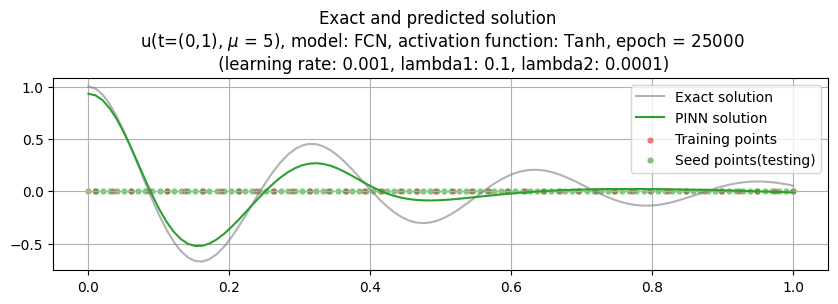

Saved the checkpoint corresponding to epoch: 25000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.046385757625103) = loss1(0.004874960985034704) + 0.1 * loss2(8.345172682311386e-05) + 0.0001 * loss3(415.0245361328125)


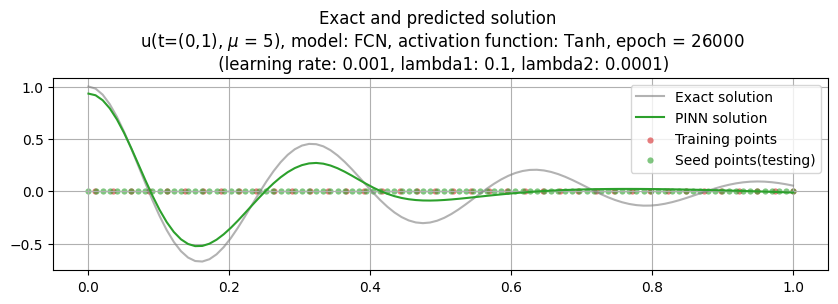

Saved the checkpoint corresponding to epoch: 26000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.04576532915234566) = loss1(0.004735738039016724) + 0.1 * loss2(7.217349048005417e-05) + 0.0001 * loss3(410.2237548828125)


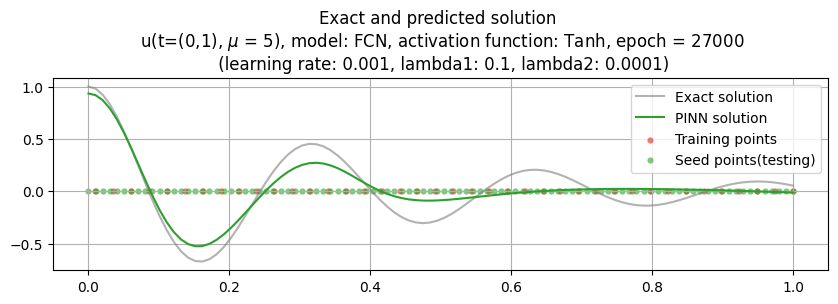

Saved the checkpoint corresponding to epoch: 27000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.045219406485557556) = loss1(0.0046247197315096855) + 0.1 * loss2(6.74418406561017e-05) + 0.0001 * loss3(405.87945556640625)


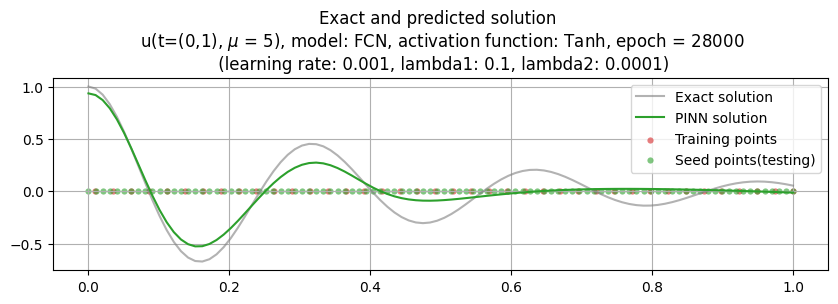

Saved the checkpoint corresponding to epoch: 28000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.04473269358277321) = loss1(0.004508864134550095) + 0.1 * loss2(5.1505387091310695e-05) + 0.0001 * loss3(402.186767578125)


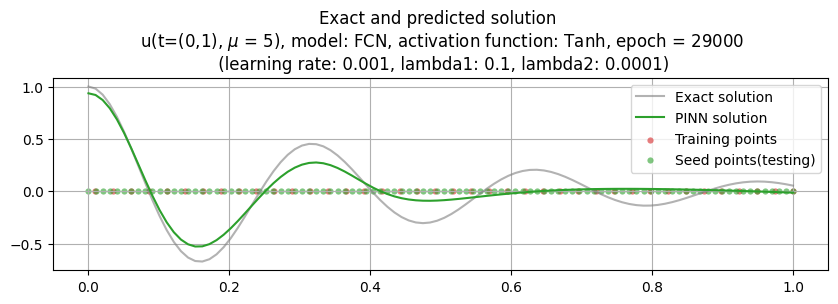

Saved the checkpoint corresponding to epoch: 29000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.044292811304330826) = loss1(0.0044726780615746975) + 0.1 * loss2(8.20095301605761e-05) + 0.0001 * loss3(398.11932373046875)


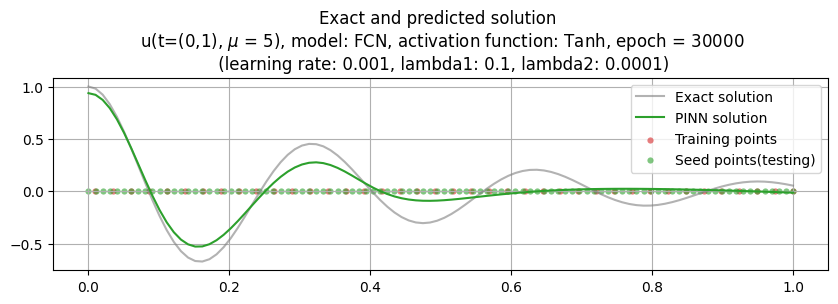

Saved the checkpoint corresponding to epoch: 30000
Shape of ic1 residuals: torch.Size([40, 1])
Decomposition of the loss terms: 
 loss(0.04389265179634094) = loss1(0.0043575335294008255) + 0.1 * loss2(5.289579348755069e-05) + 0.0001 * loss3(395.2983093261719)


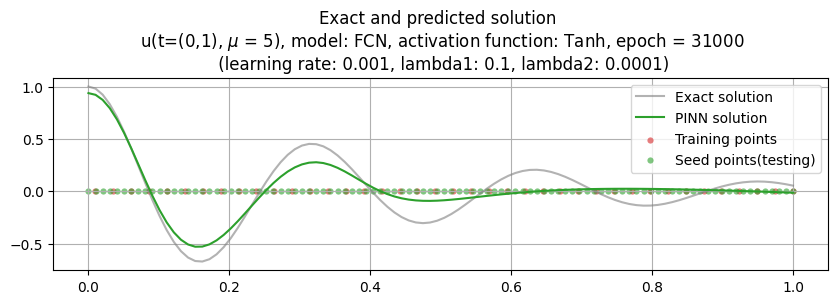

Saved the checkpoint corresponding to epoch: 31000
Stopping training at epoch 31122 as the loss stabilized within the threshold.
max_min_range = 9.21487808227539e-05 
 absolute_loss_value: 0.04388474004343152 
Training elapsed time (s): 68.04595351219177


In [19]:
epochs = 50001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
# Plot the loss history as before

loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []
loss_total_history = []

loss_history = []  # To track loss over epochs
threshold = 0.0001  # Predetermined threshold for stopping
check_range = 200
#initial_loss_value = 0.05

for i in range(epochs):
    optimiser.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= original_model(ic1_t_mu)
    
    residuals_ic1 = ic1_predicted - ic1_scope
    
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    
    residuals_ic2 = ic2_du_dt- ic2_scope
    
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = original_model(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    
    residuals_differential_equation = physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted 
    
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    loss_total_history.append(loss.item())
    loss_history.append(loss.item())
    if i ==1:
        
        initial_loss_value = loss.item()        
    
    loss.backward()
    optimiser.step()
    
    # Update loss history and ensure it contains the losses of the last check_range epochs
    if len(loss_history) > check_range:
        loss_history.pop(0)  # Remove the oldest loss value
    
    # Check if the difference between max and min loss in the last 100 epochs is within the threshold
    max_min_range = max(loss_history) - min(loss_history)
    absolut_loss_value = sum(loss_history) / len(loss_history)
    if len(loss_history) == check_range and max_min_range <= threshold and  absolut_loss_value < initial_loss_value:
        print(f"Stopping training at epoch {i} as the loss stabilized within the threshold.")
        print(f"max_min_range = {max_min_range} \n absolute_loss_value: {absolut_loss_value} ")
        break
    
    if i%1000 == 0:
        print(f"Shape of ic1 residuals: {residuals_ic1.shape}")
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted = original_model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        #plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation()}, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: Tanh, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")

        plt.grid()
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": original_model.state_dict(),
                    "optimiser_state_dict": optimiser.state_dict(),
                    "loss": loss,
                   },                    
                    f"lr{learning_rate}_epoch{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")
        

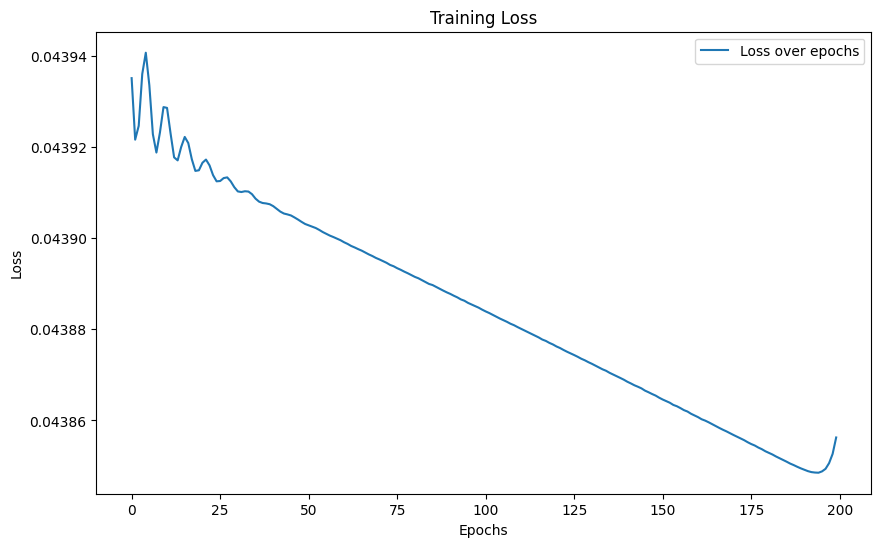

In [20]:
# Plot the loss history as before
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


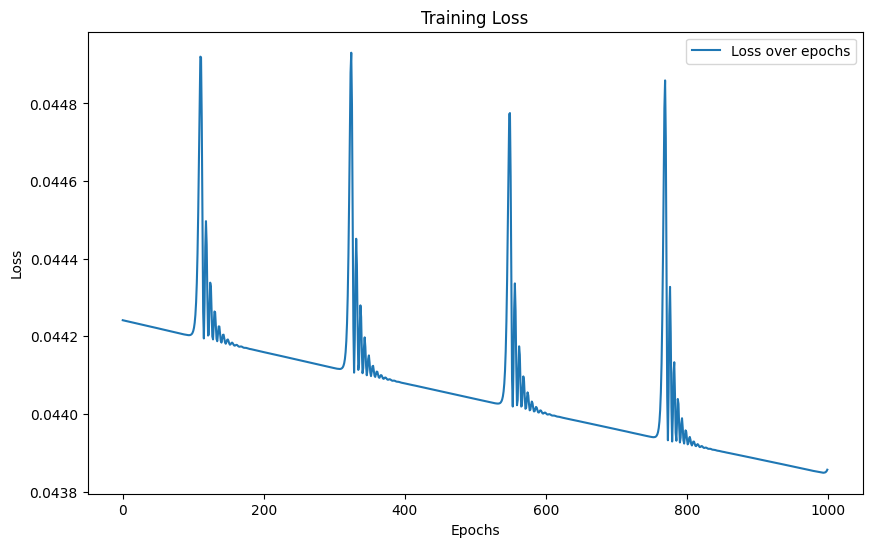

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(loss_total_history[-1000:], label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

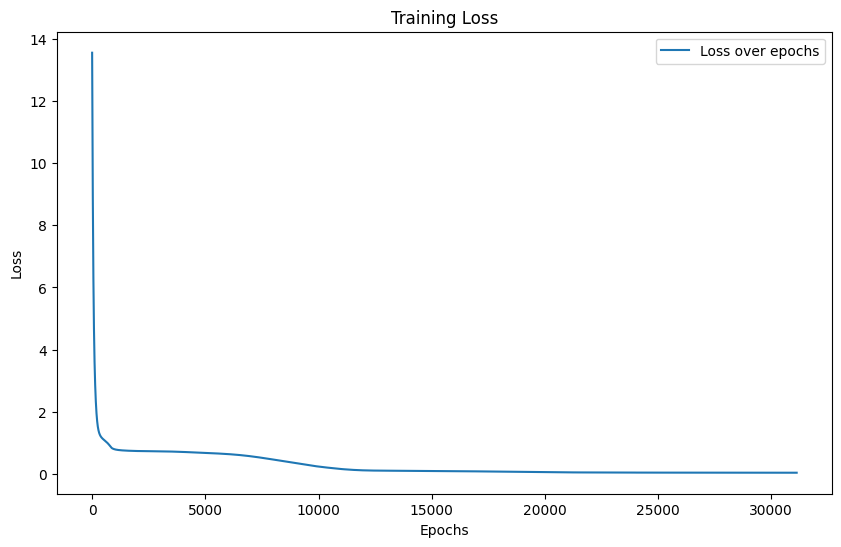

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(loss_total_history, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

### Load the checkpoint:

In [ ]:
model = FCN(2,1,64,4) # N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYER
#pinn_gpu.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
checkpoint = torch.load(f"lr{learning_rate}_epoch{i}.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
epochs = checkpoint["epoch"]
loss = checkpoint["loss"]

In [ ]:
checkpoint["epoch"]

## STEP 6: Continue training (Checkpointing)

In [ ]:
epochs

In [ ]:
epochs_delta = epochs + 18000

In [ ]:
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:
loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs, epochs_delta+1): 
    optimiser.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimiser.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted = model(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {model.__class__.__name__}, activation function: {model.activation()}, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
        torch.save({
                    "epoch": i,
                    "model_state_dict": model.state_dict(),
                    "optimiser_state_dict": optimiser.state_dict(),
                    "loss": loss,
                   },                    
                    f"lr{learning_rate}_epoch{i}.pth")
        print(f"Saved the checkpoint corresponding to epoch: {i}")
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")
        

## STEP 7: Investigation of the loss terms

In [ ]:
# plot the contribution of every loss term (loss1, loss2 and loss3)
fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (15,5))
#fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh #{original_model.activation()}# activation function \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)
fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh activation function \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)

loss1_2.plot(loss_ic1_history, label = "loss1: residuals of u(t=0)=1", color = "tab:red")
loss1_2.plot(loss_ic2_history, label = "loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
loss1_2.set_title("loss1: (u(t=0)=1) and loss2: (du/dt(t=0)=0)")
loss1_2.set_xlabel("epochs")
loss1_2.set_ylabel("residuals")
loss1_2.grid()
loss1_2.legend()

loss3.plot(loss_differential_equation_history, label= "loss3: residuals of the differential equation", color = "tab:grey")
loss3.set_title("loss3: residuals of the differential equation")
loss3.set_xlabel("epochs")
loss3.set_ylabel("residuals")
loss3.legend()
loss3.grid()

## STEP 8: Inference

In [ ]:
test_mu = 10
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size()

In [ ]:
test_predicted = model(test_in_t_constant_mu)

In [ ]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])

In [ ]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_in_t_mu[0], 
            torch.zeros_like(test_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {model.__class__.__name__}, activation function: {model.activation()} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
plt.grid()
plt.legend()
plt.show()

## STEP9: Training using a different initialization & activation function

In [ ]:
activation_func = "LeakyReLU"
model_init = FCN_init(2,1,64,4, activation= activation_func)
model_init.parameters

In [ ]:
#plt.imshow(model_init.state_dict()["fcs.0.weight"])

In [ ]:
model_init.fcs

In [ ]:
print(model_init.parameters)
print(model_init.state_dict().keys())

In [ ]:
test_predicted_init = model_init(test_in_t_constant_mu)

In [ ]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted_init[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1, model: {model_init.__class__.__name__}, activation function: {activation_func}()")
plt.legend()
plt.show()

## STEP10: Inference Case (Check for a fixed value of mu)

In [ ]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")b

In [ ]:
test_predicted_init = model_init(test_in_t_constant_mu)
#print(test_predicted)

In [ ]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_in_t_mu[0], 
                 test_predicted_init[:,0].detach().numpy(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_in_t_mu[0], 
        torch.zeros_like(test_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), epoch = 1, model: {model.__class__.__name__}, activation function: {activation_func}()")
plt.grid()
plt.legend()
plt.show()

In [ ]:
ic1_t_mu
physic_domain_t_mu
loss_ic1

In [ ]:
optimizer_init = torch.optim.Adam(model_init.parameters(), lr= learning_rate)
epochs = 10001
start = time.time()
# Creation of the variables loss1_history, loss2_history and loss3_history for printing the evolution of the contribution of every loss term:

loss_ic1_history = []
loss_ic2_history = []
loss_differential_equation_history = []

for i in range(epochs):
    optimizer_init.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model_init(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
    loss_ic1_history.append(loss_ic1.item())


    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
    loss_ic2_history.append(loss_ic2.item())

    # compute physic loss:
    physic_domain_predicted = model_init(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)
    loss_differential_equation_history.append(loss_differential_equation.item())
    
    loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
    
    loss.backward()
    optimizer_init.step()
    
    
    if i%1000 == 0:
        print(f'Decomposition of the loss terms: \n loss({loss}) = loss1({loss_ic1}) + {lambda1} * loss2({loss_ic2}) + {lambda2} * loss3({loss_differential_equation})')
        
        test_predicted_init = model_init(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                test_in_t_mu[0], 
                test_predicted_init[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    test_in_t_mu[0], 
                    torch.zeros_like(test_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {model_init.__class__.__name__}, activation function: {activation_func}, epoch = {i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
end = time.time()
execution_time = (end - start)
print(f"Training elapsed time (s): {execution_time}")